# Download the dataset

In [1]:
import os
import requests
import zipfile
import io

dataset_url = "https://www.kaggle.com/api/v1/datasets/download/firecastrl/us-wildfire-dataset"
destination = "Wildfire_Dataset.csv"
if os.path.isfile(destination) == False:
    print(f"Downloading dataset from {dataset_url}...")
    zip = requests.get(dataset_url, allow_redirects=True)
    zipfile.ZipFile(io.BytesIO(zip.content)).extractall()
else:
    print(f"{destination} already exists.  Skipping download.")

print("Dataset is ready. ")

Wildfire_Dataset.csv already exists.  Skipping download.
Dataset is ready. 


# Dataset Shape

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("Wildfire_Dataset.csv", parse_dates=["datetime"])

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
df. head()

Shape: (9509925, 19)

Columns: ['latitude', 'longitude', 'datetime', 'Wildfire', 'pr', 'rmax', 'rmin', 'sph', 'srad', 'tmmn', 'tmmx', 'vs', 'bi', 'fm100', 'fm1000', 'erc', 'etr', 'pet', 'vpd']


,latitude,longitude,datetime,Wildfire,pr,rmax,rmin,sph,srad,tmmn,tmmx,vs,bi,fm100,fm1000,erc,etr,pet,vpd
0,48.128431,-97.276685,2018-08-15,No,0.0,78.6,14.9,0.00582,272.6,282.0,301.6,3.0,40.0,10.2,12.2,54.0,7.5,5.5,1.59
1,48.128431,-97.276685,2018-08-16,No,0.0,80.4,13.9,0.00676,264.0,283.9,304.9,3.0,40.0,9.7,12.0,56.0,8.2,5.9,1.93
2,48.128431,-97.276685,2018-08-17,No,0.0,70.9,20.4,0.00672,265.6,285.8,300.7,3.1,40.0,9.2,11.9,56.0,7.2,5.3,1.51
3,48.128431,-97.276685,2018-08-18,No,5.0,65.2,19.4,0.00756,261.4,289.0,303.3,5.1,0.0,9.9,12.0,40.0,10.0,6.9,1.85
4,48.128431,-97.276685,2018-08-19,No,0.0,100.0,42.2,0.00895,166.8,283.8,296.5,4.7,41.0,11.8,12.1,47.0,4.6,3.4,0.66


# Class Distribution

Wildfire
No     9007860
Yes     502065
Name: count, dtype: int64




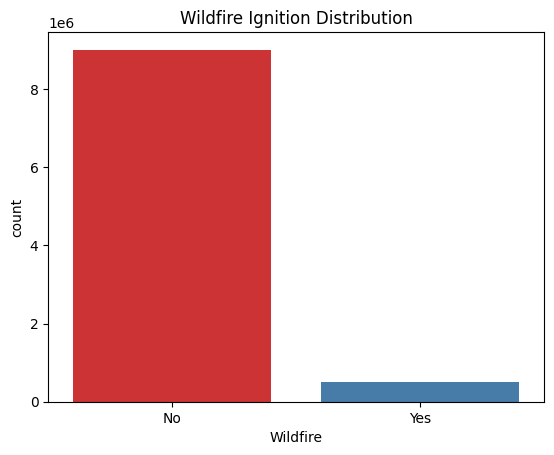

In [3]:
print(df["Wildfire"].value_counts())
print("\n")

sns.countplot(x="Wildfire", data=df, hue="Wildfire", palette="Set1", legend=False)
plt.title("Wildfire Ignition Distribution")
plt.show()

# Wildfire by Lat/Long

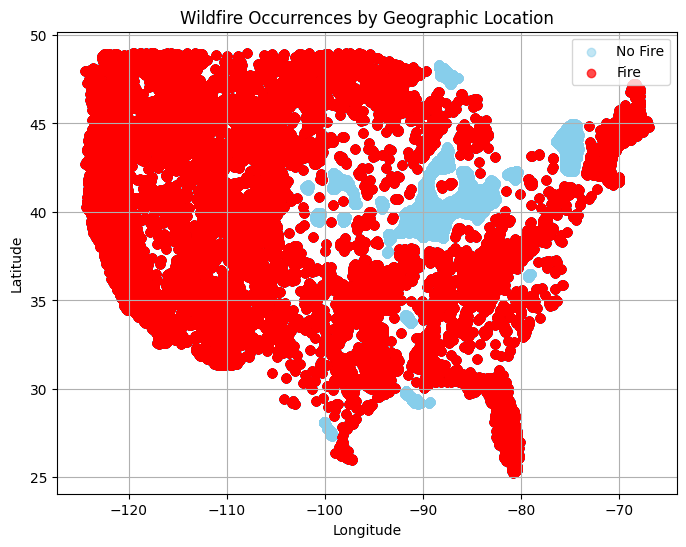

In [4]:
plt.figure(figsize=(8, 6))

plt.scatter(
    df[df["Wildfire"] == "No"]["longitude"],
    df[df["Wildfire"] == "No"]["latitude"],
    color="skyblue",
    label="No Fire",
    alpha=0.5,
)

plt.scatter(
    df[df["Wildfire"] == "Yes"]["longitude"],
    df[df["Wildfire"] == "Yes"]["latitude"],
    color="red",
    label="Fire",
    alpha=0.7,
)

plt.title("Wildfire Occurrences by Geographic Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")
plt. grid(True)
plt.show()

# Add Month, Year, Day of Year to Columns

In [5]:
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["dayofyear"] = df["datetime"].dt.dayofyear

# Split Data Into 75 Day Blocks

In [6]:
SEQ_LEN = 75
FEATURES = [
    "pr",
    "rmax",
    "rmin",
    "sph",
    "srad",
    "tmmn",
    "tmmx",
    "vs",
    "bi",
    "fm100",
    "fm1000",
    "erc",
    "etr",
    "pet",
    "vpd",
]

df = df.sort_values(["latitude", "longitude", "datetime"]).reset_index(drop=True)
df["seq_id"] = np.arange(len(df)) // SEQ_LEN

n_features = len(FEATURES)
n_seq = len(df) // SEQ_LEN

df_trimmed = df. iloc[: n_seq * SEQ_LEN]. copy()

X_flat = df_trimmed[FEATURES].values
seqs = X_flat. reshape((n_seq, SEQ_LEN, n_features))

wildfire_indicator = (df_trimmed["Wildfire"] == "Yes"). astype(int)
labels = wildfire_indicator.groupby(df_trimmed["seq_id"]).max().values

print(f"Final seqs shape: {seqs.shape}")
print(f"Final labels shape: {labels.shape}")

fill_value = 32767.0
valid_mask = ~np.any(seqs == fill_value, axis=(1, 2))
seqs = seqs[valid_mask]
labels = labels[valid_mask]
print(f"Valid seqs shape: {seqs. shape}")
print(f"Valid labels shape: {labels. shape}")

Final seqs shape: (126799, 75, 15)
Final labels shape: (126799,)
Valid seqs shape: (126456, 75, 15)
Valid labels shape: (126456,)


# Train/Test Split

In [7]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(
    seqs, labels, test_size=0.2, random_state=42, stratify=labels
)

# Reshape for 2D models (Random Forest, Logistic Regression)
train_x_2d = train_x.reshape((train_x.shape[0], -1))
test_x_2d = test_x.reshape((test_x.shape[0], -1))

print(f"Train X shape: {train_x_2d.shape}, Train y shape: {train_y.shape}")
print(f"Test X shape: {test_x_2d.shape}, Test y shape: {test_y.shape}")
print(f"Train X 3D shape: {train_x. shape}, Test X 3D shape: {test_x.shape}")

Train X shape: (101164, 1125), Train y shape: (101164,)
Test X shape: (25292, 1125), Test y shape: (25292,)
Train X 3D shape: (101164, 75, 15), Test X 3D shape: (25292, 75, 15)


# Standardize The Data

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x_2d_scaled = scaler.fit_transform(train_x_2d)
test_x_2d_scaled = scaler.transform(test_x_2d)

print("Data standardization complete")

Data standardization complete


# Logistic Regression Training

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_model. fit(train_x_2d_scaled, train_y)

lr_pred = lr_model.predict(test_x_2d_scaled)
lr_pred_proba = lr_model. predict_proba(test_x_2d_scaled)[:, 1]

print("\nLogistic Regression Results:")
print(f"Accuracy: {accuracy_score(test_y, lr_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(test_y, lr_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(test_y, lr_pred, target_names=['No Fire', 'Fire']))

Training Logistic Regression...

Logistic Regression Results:
Accuracy: 0.7390
ROC-AUC: 0.6630

Classification Report:
              precision    recall  f1-score   support

     No Fire       0.75      0.97      0.85     18635
        Fire       0.53      0.08      0.14      6657

    accuracy                           0.74     25292
   macro avg       0.64      0.53      0.49     25292
weighted avg       0.69      0.74      0.66     25292



# Random Forest Training

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight

print("Training Random Forest...")

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(train_x_2d_scaled, train_y)

rf_pred = rf_model.predict(test_x_2d_scaled)
rf_pred_proba = rf_model.predict_proba(test_x_2d_scaled)[:, 1]

print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(test_y, rf_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(test_y, rf_pred_proba):.4f}")
print("\nClassification Report:")
print(classification_report(test_y, rf_pred, target_names=['No Fire', 'Fire']))

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s



Random Forest Results:
Accuracy: 0.7171
ROC-AUC: 0.7090

Classification Report:
              precision    recall  f1-score   support

     No Fire       0.80      0.82      0.81     18635
        Fire       0.46      0.44      0.45      6657

    accuracy                           0.72     25292
   macro avg       0.63      0.63      0.63     25292
weighted avg       0.71      0.72      0.72     25292



[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished


# Feature Importance (Random Forest)

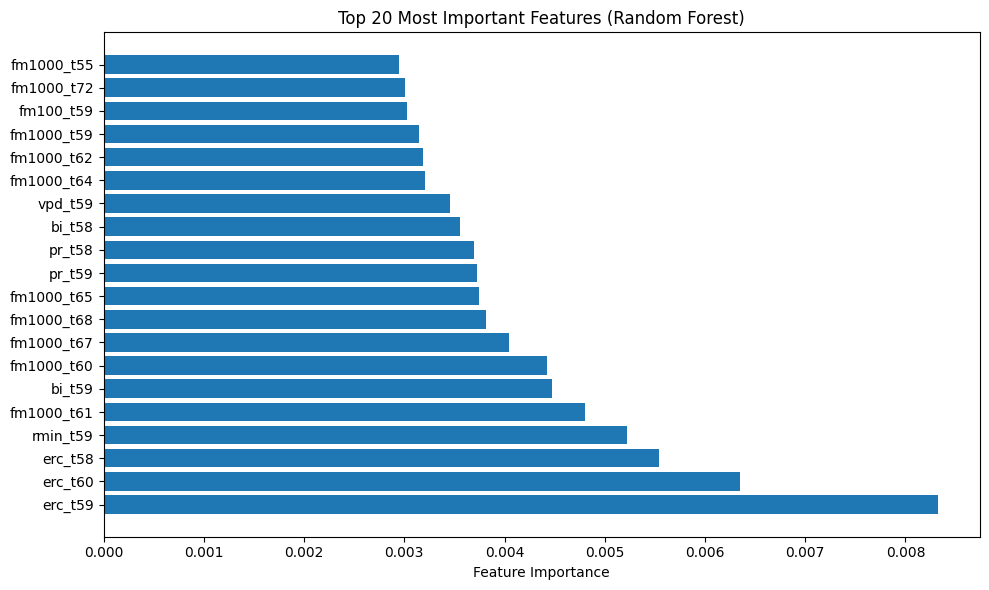

In [11]:
# Get feature importance
feature_importance = rf_model.feature_importances_

# Create feature names for each time step
feature_names = [f"{feat}_t{t}" for t in range(SEQ_LEN) for feat in FEATURES]

# Get top 20 important features
top_indices = np.argsort(feature_importance)[-20:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(top_features)), top_importance)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

# LSTM Model Training

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras. models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

print("Building LSTM Model...")

# Normalize the 3D data for LSTM
scaler_3d = StandardScaler()
train_x_3d_scaled = train_x. copy()
test_x_3d_scaled = test_x.copy()

# Scale each sequence independently
for i in range(train_x_3d_scaled. shape[0]):
    train_x_3d_scaled[i] = scaler. fit_transform(train_x_3d_scaled[i])

for i in range(test_x_3d_scaled.shape[0]):
    test_x_3d_scaled[i] = scaler.transform(test_x_3d_scaled[i])

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LEN, n_features)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print(lstm_model.summary())

print("\nTraining LSTM Model...")
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = lstm_model.fit(
    train_x_3d_scaled, train_y,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("LSTM training complete")

Building LSTM Model...


/home/jesus/DataMiningProject/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-11-30 17:04:12.027145: W tensorflow/core/framework/op_kernel.cc:1842] UNKNOWN: JIT compilation failed.
2025-11-30 17:04:12.027159: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: UNKNOWN: JIT compilation failed.


UnknownError: {{function_node __wrapped__Sign_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sign] name: 

# LSTM Model Evaluation

In [ ]:
print("Evaluating LSTM Model...")

lstm_pred_proba = lstm_model.predict(test_x_3d_scaled)
lstm_pred = (lstm_pred_proba > 0.5).astype(int). flatten()

print("\nLSTM Results:")
print(f"Accuracy: {accuracy_score(test_y, lstm_pred):. 4f}")
print(f"ROC-AUC: {roc_auc_score(test_y, lstm_pred_proba. flatten()):.4f}")
print("\nClassification Report:")
print(classification_report(test_y, lstm_pred, target_names=['No Fire', 'Fire']))

# LSTM Training History

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('LSTM Model Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(history.history['accuracy'], label='Training Accuracy')
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('LSTM Model Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# ROC Curves Comparison

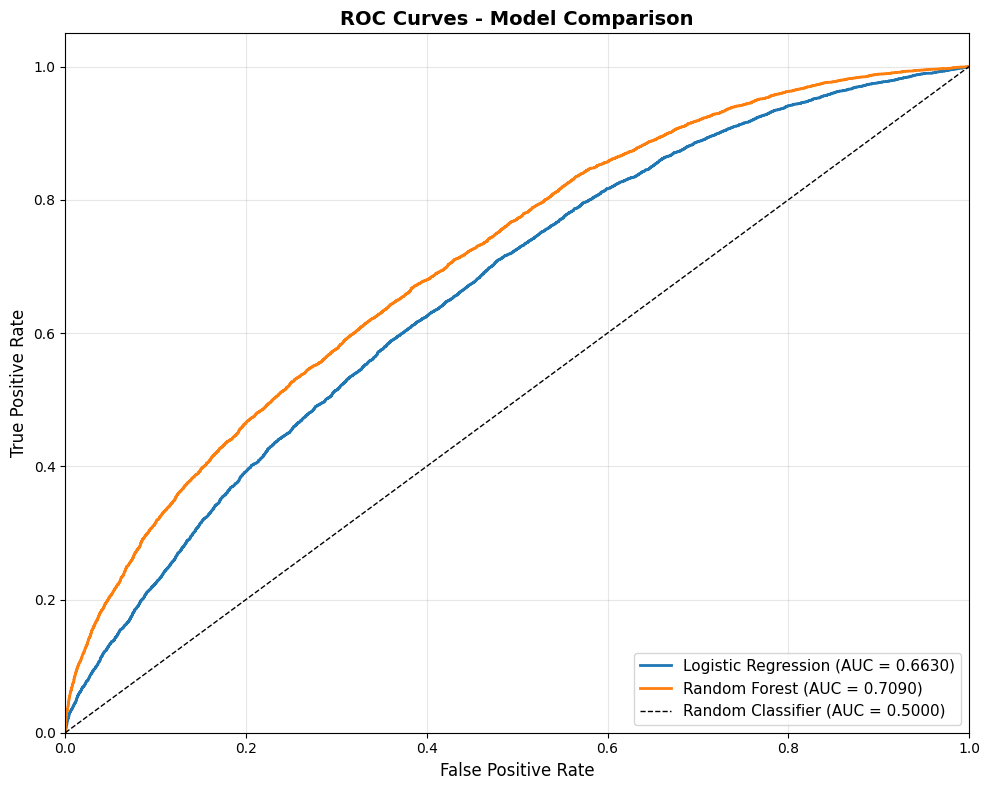


MODEL COMPARISON SUMMARY

Logistic Regression - AUC: 0.6630
Random Forest        - AUC: 0.7090

Best Model: Random Forest


In [17]:
# Calculate ROC curves
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_pred_proba)
lr_auc = roc_auc_score(test_y, lr_pred_proba)

rf_fpr, rf_tpr, _ = roc_curve(test_y, rf_pred_proba)
rf_auc = roc_auc_score(test_y, rf_pred_proba)

#lstm_fpr, lstm_tpr, _ = roc_curve(test_y, lstm_pred_proba)
#lstm_auc = roc_auc_score(test_y, lstm_pred_proba. flatten())

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_auc:.4f})', linewidth=2)
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.4f})', linewidth=2)
#plt.plot(lstm_fpr, lstm_tpr, label=f'LSTM (AUC = {lstm_auc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt. ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print("MODEL COMPARISON SUMMARY")
print("="*50)
print(f"\nLogistic Regression - AUC: {lr_auc:.4f}")
print(f"Random Forest        - AUC: {rf_auc:.4f}")
#print(f"LSTM                 - AUC: {lstm_auc:.4f}")
print("\nBest Model: ", end="")
if max(lr_auc, rf_auc) == lr_auc:
    print("Logistic Regression")
elif max(lr_auc, rf_auc) == rf_auc:
    print("Random Forest")
else:
    print("LSTM")

# Confusion Matrices

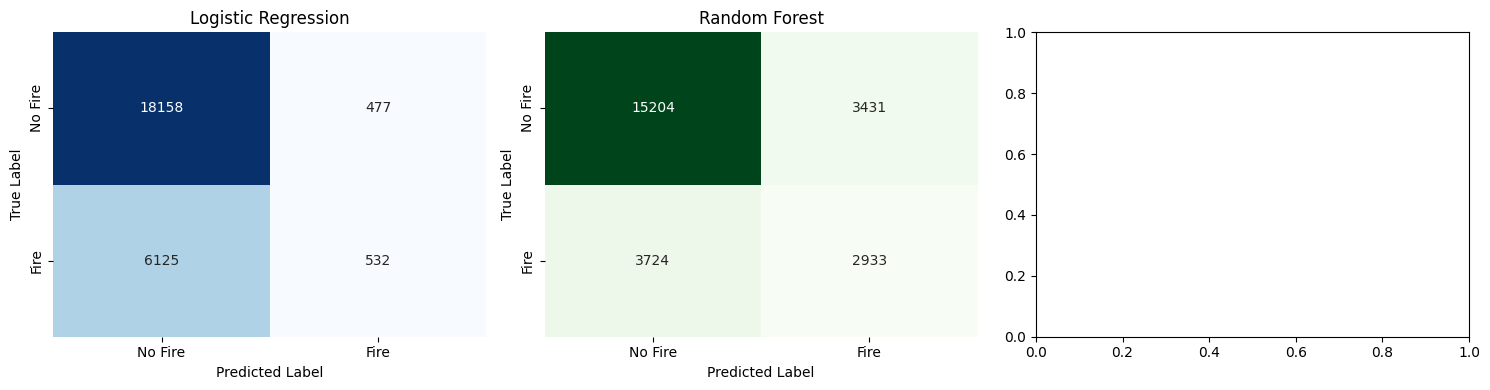

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Logistic Regression
lr_cm = confusion_matrix(test_y, lr_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Logistic Regression')
axes[0].set_ylabel('True Label')
axes[0]. set_xlabel('Predicted Label')
axes[0].set_xticklabels(['No Fire', 'Fire'])
axes[0].set_yticklabels(['No Fire', 'Fire'])

# Random Forest
rf_cm = confusion_matrix(test_y, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Random Forest')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')
axes[1].set_xticklabels(['No Fire', 'Fire'])
axes[1].set_yticklabels(['No Fire', 'Fire'])

# LSTM
#lstm_cm = confusion_matrix(test_y, lstm_pred)
#sns. heatmap(lstm_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False)
#axes[2].set_title('LSTM')
#axes[2].set_ylabel('True Label')
#axes[2].set_xlabel('Predicted Label')
#axes[2].set_xticklabels(['No Fire', 'Fire'])
#axes[2].set_yticklabels(['No Fire', 'Fire'])

plt.tight_layout()
plt.show()

# Precision-Recall Curves

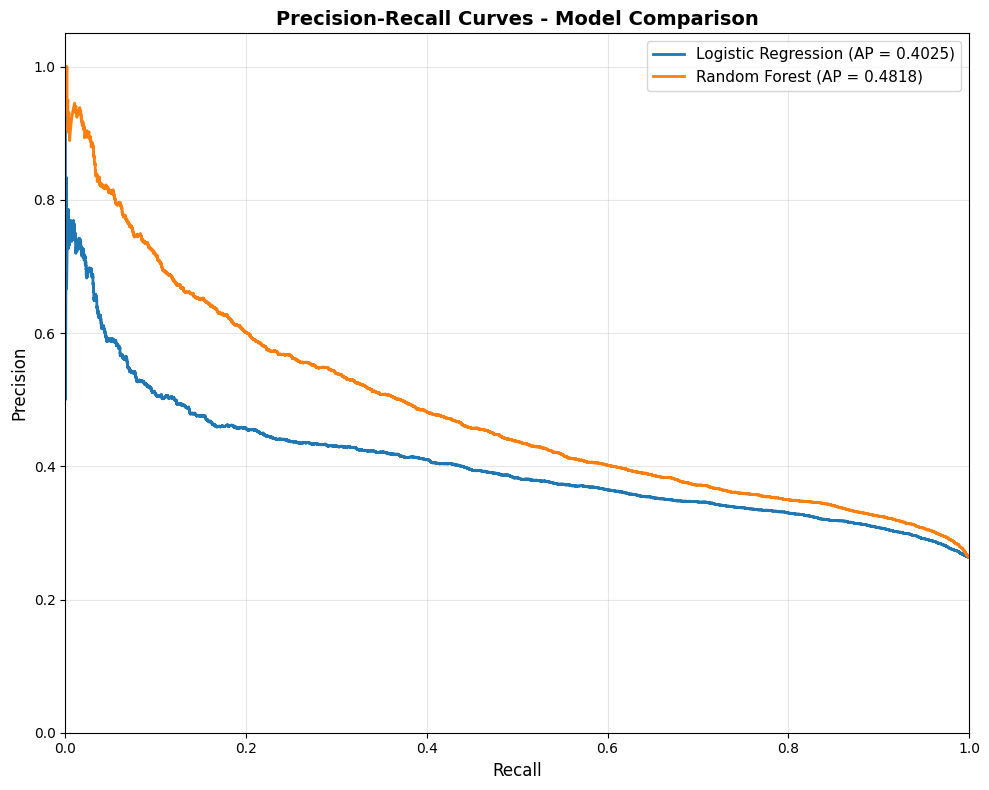

In [21]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Calculate Precision-Recall curves
lr_precision, lr_recall, _ = precision_recall_curve(test_y, lr_pred_proba)
lr_ap = average_precision_score(test_y, lr_pred_proba)

rf_precision, rf_recall, _ = precision_recall_curve(test_y, rf_pred_proba)
rf_ap = average_precision_score(test_y, rf_pred_proba)

#lstm_precision, lstm_recall, _ = precision_recall_curve(test_y, lstm_pred_proba)
#lstm_ap = average_precision_score(test_y, lstm_pred_proba. flatten())

# Plot Precision-Recall curves
plt.figure(figsize=(10, 8))
plt.plot(lr_recall, lr_precision, label=f'Logistic Regression (AP = {lr_ap:.4f})', linewidth=2)
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AP = {rf_ap:.4f})', linewidth=2)
#plt.plot(lstm_recall, lstm_precision, label=f'LSTM (AP = {lstm_ap:.4f})', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

# Detailed Metrics Comparison

In [25]:
from sklearn.metrics import precision_score, recall_score, f1_score

models = ['Logistic Regression', 'Random Forest', 'LSTM']
predictions = [lr_pred, rf_pred]
probabilities = [lr_pred_proba, rf_pred_proba]

metrics_data = []

for model_name, pred, prob in zip(models, predictions, probabilities):
    accuracy = accuracy_score(test_y, pred)
    precision = precision_score(test_y, pred)
    recall = recall_score(test_y, pred)
    f1 = f1_score(test_y, pred)
    auc = roc_auc_score(test_y, prob)
    
    metrics_data.append({
        'Model': model_name,
        'Accuracy': f"{accuracy:.4f}",
        'Precision': f"{precision:.4f}",
        'Recall': f"{recall:.4f}",
        'F1-Score': f"{f1:.4f}",
        'AUC': f"{auc:.4f}"
    })

metrics_df = pd.DataFrame(metrics_data)
print("\n")
print("DETAILED METRICS COMPARISON")

print("\n")

print(metrics_df.to_string(index=False))
print("\n")



DETAILED METRICS COMPARISON


              Model Accuracy Precision Recall F1-Score    AUC
Logistic Regression   0.7390    0.5273 0.0799   0.1388 0.6630
      Random Forest   0.7171    0.4609 0.4406   0.4505 0.7090


